In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import geopandas as gpd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp

import numpy as np
from PIL import Image

from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc

In [2]:
def read_band(href):
    with rasterio.open(href) as ds:
        aoi_bounds = features.bounds(area_of_interest)
        warped_aoi_bounds = warp.transform_bounds("epsg:4326", ds.crs, *aoi_bounds)
        aoi_window = windows.from_bounds(transform=ds.transform, *warped_aoi_bounds)
        return ds.read(1, window=aoi_window)

In [3]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [4]:
def get_band(ds, band_name):
    return read_band(pc.sign(find_asset_by_band_common_name(ds, band_name).href)).astype(float)

In [5]:
#Area of interest
area_of_interest = gpd.read_file('data/fiji_test.geojson')

In [6]:
area_of_interest.explore(column='Name')

In [7]:
time_of_interest = "2019-01-01/2020-12-31"

In [8]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(
    collections=["landsat-8-c2-l2"],
    intersects=area_of_interest.geometry[0],
    datetime=time_of_interest,
    query={"eo:cloud_cover": {"lt": 50}},
)

# Check how many items were returned
items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 25 Items


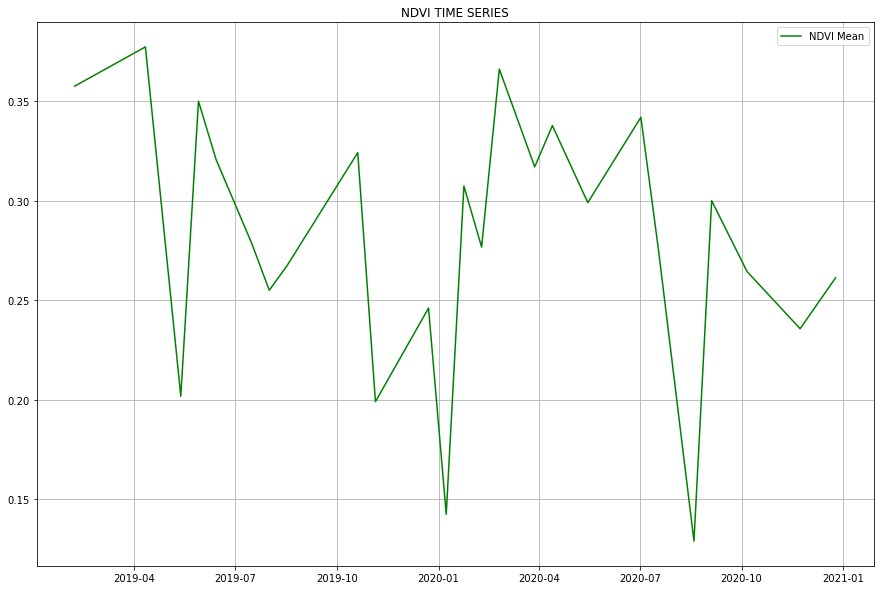

In [9]:
date = []
mean_ndvi = []
for image in items:
    date.append(image.datetime)
    red = get_band(image, 'red')
    nir = get_band(image, 'nir08') 
    NDVI = (nir - red) / (nir + red)

    ndvi_matrix = np.matrix(NDVI)
   
    mean_ndvi.append(ndvi_matrix.mean())
    
fig = figure(figsize=(15, 10), frameon=True)
plt.plot(date , mean_ndvi, color= 'green',label='NDVI Mean')
plt.legend(loc='best')
plt.title("NDVI TIME SERIES")
plt.grid()
plt.show()